# Autometic **Essay Scoring** Problem
> ### Genessis Lab
---

# 1. Library Load

In [47]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk # it's for Stopword
import re
import collections
import itertools
import re,string,unicodedata


from gensim.utils import tokenize
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Layer

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# 2. Data Load

In [35]:
dataset = pd.read_table("./essay_dataset_encoding.txt",sep="\t",encoding='utf-8')
inputs, labels = dataset['essay'], dataset['score']
dataset

,essay_id,essay_set,essay,score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
9475,21626,6,In most stories mothers and daughters are eit...,35
9476,21628,6,I never understood the meaning laughter is th...,32
9477,21629,6,"When you laugh, is @CAPS5 out of habit, or is ...",40
9478,21630,6,Trippin' on fen...,40


In [36]:
inputs[0]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

# 3. EDA

### 1) 각 Essay Set별 Score점수 비교

In [37]:
def cv(x): # 변동 계수
    return x.std() / x.mean()

dataset.groupby('essay_set')['score'].agg(['count','mean','std',cv])

,count,mean,std,cv
essay_set,,,,
1,1783,8.528323,1.538565,0.180407
2,1800,3.415556,0.774512,0.226760
3,1805,2.408864,0.970821,0.403020
4,1800,2.720000,0.970630,0.356849
5,1569,16.062460,4.585350,0.285470
6,723,36.950207,5.753502,0.155710


### 2) 각 단어의 Tokenization과 Stopword 제거

In [48]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

inputs_clean = inputs.apply(lambda x: clean_text(x))

In [49]:
sentences=[]
for text in inputs_clean:
    sentences.append(list(tokenize(text)))

sentences_rm = []
for y in sentences:
    temp=[]
    for x in y:
        if x.lower() not in list(STOPWORDS):
            temp.append(x.lower())
    sentences_rm.append(temp)

### 3) 각 단어의 사용 빈도가 높은 상위 30개 단어 추출

In [50]:
sentences_one = list(itertools.chain(*sentences_rm))
counts = dict(collections.Counter(sentences_one))
counts_orders = sorted(counts.items(), key=lambda x: x[1], reverse=True)
selected_word=pd.DataFrame(counts_orders[0:30],columns=['word','count'])
selected_word

,word,count
0,people,20398
1,would,13113
2,computers,10750
3,computer,9307
4,like,9023
5,one,8893
6,time,8725
7,get,8203
8,books,8077
9,could,7243


### 4. Word2Vec 적용하여 각 단어들 간의 관계성 분석

- 단어 데이터에 Word2Vec 적용

In [51]:
max_length = max([len(x)for x in sentences_rm])
model = Word2Vec(sentences_rm, window=5, min_count=1, workers=6)
word_vectors = model.wv

> `person` 과 `computer`의 유사도

In [52]:
word_vectors.similarity(w1='person', w2='computer')

0.31125927

> `people`단어의 가장 비슷한 단어는?

In [53]:
pd.DataFrame(model.wv.most_similar('people'),columns=['word','similarity'])

,word,similarity
0,others,0.817510
1,ways,0.682282
2,conclusion,0.652827
3,things,0.649997
4,peoplethe,0.646850
5,fruitless,0.630725
6,actually,0.622269
7,discoverd,0.619476
8,personally,0.609822
9,promblems,0.609253


> `computers` 단어의 가장 비슷한 단어는?

In [54]:
pd.DataFrame(model.wv.most_similar('computers'),columns=['word','similarity'])

,word,similarity
0,computer,0.754152
1,omputers,0.730704
2,society,0.710368
3,education,0.698264
4,shoud,0.678649
5,secondly,0.659596
6,computors,0.649897
7,daily,0.646548
8,advertion,0.645080
9,conclusion,0.642396


> person : society = computers : ? 관계는

In [55]:
pd.DataFrame(model.wv.most_similar(positive=['computers', 'society'], negative=['person']),columns=['word','similarity']) # person:society=computers:?

,word,similarity
0,technology,0.760601
1,distroy,0.705548
2,future,0.701550
3,sociaty,0.684685
4,education,0.679560
5,learner,0.679149
6,moderatly,0.665634
7,comprimise,0.652243
8,greatly,0.649829
9,todays,0.649685


- 2차원 화면에 표현 하기 위하여 차원축소

In [56]:
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df

,x,y
people,33.953930,-40.960941
would,31.663216,-43.224716
computers,34.356815,-38.822887
computer,34.364555,-39.035450
like,33.007038,-42.890083
...,...,...
anyane,-14.749132,19.760927
whycomputers,-18.756136,8.949681
thev,4.373436,4.585466
leperdy,-15.794237,31.771669


* 빈도수가 높은 상위 100개 단어를 다차원 공간에 Ploting

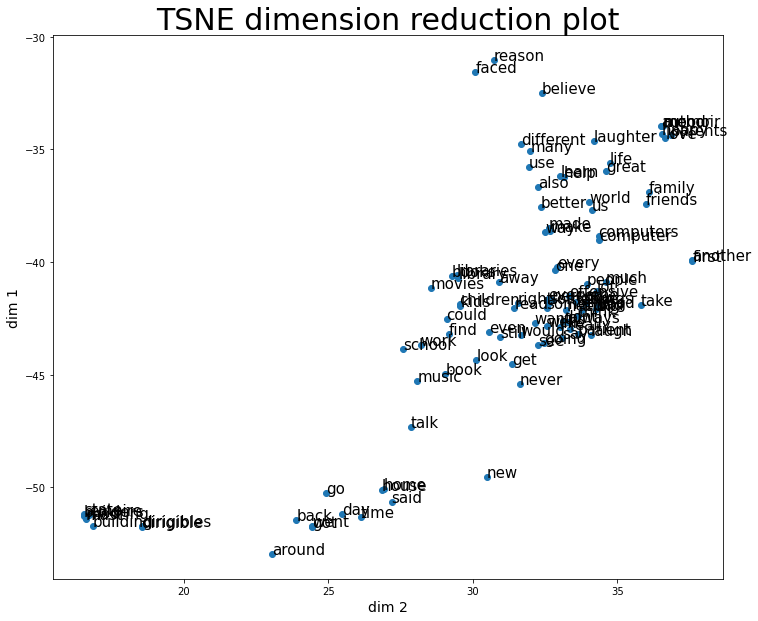

In [57]:
selected_word=pd.DataFrame(counts_orders[0:100],columns=['word','count'])

dfs=df[df.index.isin(list(selected_word['word']))]
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(dfs['x'], dfs['y'])
for word, pos in dfs.iterrows():
    ax.annotate(word, pos, fontsize=15)
plt.title('TSNE dimension reduction plot', fontsize=30)
plt.xlabel("dim 2", fontsize=14)
plt.ylabel("dim 1", fontsize=14)    
plt.show()    

# 4. Modeling

### 1) 목적 : Essay 를 통해서 점수를 예측하는 모델 구축

In [14]:
vocab_size = 5000
embedding_dim = 64
max_length = 512
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
# training_portion = .8

In [15]:
# snow = nltk.stem.SnowballStemmer('english')
inputs = [x.lower() for x in inputs]
# inputs = [snow.stem(word) for word in inputs if not word in stopwords.words('english')]

In [16]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(inputs)
word_index = tokenizer.word_index
inputs_sequences = tokenizer.texts_to_sequences(inputs)
inputs_padded = pad_sequences(inputs_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [17]:
# train_size = int(len(inputs_padded) * training_portion)
x_dataset, x_test, y_dataset, y_test = train_test_split(inputs_padded, labels, test_size = 0.1, shuffle = True, random_state = 34)       
x_train, x_valid, y_train, y_valid = train_test_split(x_dataset, y_dataset, test_size = 0.2, shuffle = True, random_state = 34)

# print(train_size)
print(len(x_train))
print(len(y_train))
print(len(x_valid))
print(len(y_valid))
print(len(x_test))
print(len(y_test))

6825
6825
1707
1707
948
948


> LSTM Model

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, dropout=0.5)),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(1)
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2363392   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

> Training

In [19]:
batch_size=64
patience=30
num_epochs = 1000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 10000,
    decay_rate = 0.90
)

model.compile(
    loss=tf.keras.losses.mse,
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=1e-08,
                                 amsgrad=False,
                                 name="Adam"),
    metrics=[tf.metrics.MeanAbsoluteError()], 
)
# model.compile(
#     loss="mse",
#     optimizer="rmsprop",
#     metrics=["mae"], 
# )


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
]

history = model.fit(x_train, y_train, 
                    epochs=num_epochs, 
                    validation_data=(x_valid, y_valid),
                    batch_size = batch_size, 
                    verbose=2,
                    callbacks = callbacks
                   )

Epoch 1/1000
107/107 - 12s - loss: 83.2373 - mean_absolute_error: 5.9763 - val_loss: 37.1530 - val_mean_absolute_error: 3.7076

Epoch 00001: val_loss improved from inf to 37.15304, saving model to best_model.h5
Epoch 2/1000
107/107 - 8s - loss: 47.5649 - mean_absolute_error: 4.1272 - val_loss: 35.4917 - val_mean_absolute_error: 3.4982

Epoch 00002: val_loss improved from 37.15304 to 35.49168, saving model to best_model.h5
Epoch 3/1000
107/107 - 8s - loss: 31.4254 - mean_absolute_error: 3.4108 - val_loss: 22.0386 - val_mean_absolute_error: 3.0802

Epoch 00003: val_loss improved from 35.49168 to 22.03863, saving model to best_model.h5
Epoch 4/1000
107/107 - 8s - loss: 33.0295 - mean_absolute_error: 3.5980 - val_loss: 33.3663 - val_mean_absolute_error: 3.7416

Epoch 00004: val_loss did not improve from 22.03863
Epoch 5/1000
107/107 - 8s - loss: 35.3815 - mean_absolute_error: 3.7627 - val_loss: 19.3346 - val_mean_absolute_error: 2.8352

Epoch 00005: val_loss improved from 22.03863 to 19.33


Epoch 00044: val_loss did not improve from 6.50660
Epoch 45/1000
107/107 - 9s - loss: 5.4366 - mean_absolute_error: 1.4481 - val_loss: 7.1993 - val_mean_absolute_error: 1.5377

Epoch 00045: val_loss did not improve from 6.50660
Epoch 46/1000
107/107 - 9s - loss: 5.7585 - mean_absolute_error: 1.4738 - val_loss: 7.2961 - val_mean_absolute_error: 1.5934

Epoch 00046: val_loss did not improve from 6.50660
Epoch 47/1000
107/107 - 9s - loss: 5.3172 - mean_absolute_error: 1.4149 - val_loss: 7.8599 - val_mean_absolute_error: 1.5922

Epoch 00047: val_loss did not improve from 6.50660
Epoch 48/1000
107/107 - 9s - loss: 5.4240 - mean_absolute_error: 1.4212 - val_loss: 7.5318 - val_mean_absolute_error: 1.5664

Epoch 00048: val_loss did not improve from 6.50660
Epoch 49/1000
107/107 - 9s - loss: 5.4722 - mean_absolute_error: 1.4238 - val_loss: 6.8894 - val_mean_absolute_error: 1.5162

Epoch 00049: val_loss did not improve from 6.50660
Epoch 50/1000
107/107 - 9s - loss: 5.8873 - mean_absolute_error


Epoch 00090: val_loss did not improve from 5.99857
Epoch 91/1000
107/107 - 9s - loss: 3.7682 - mean_absolute_error: 1.1759 - val_loss: 6.6369 - val_mean_absolute_error: 1.4895

Epoch 00091: val_loss did not improve from 5.99857
Epoch 92/1000
107/107 - 9s - loss: 3.6528 - mean_absolute_error: 1.1553 - val_loss: 7.1917 - val_mean_absolute_error: 1.4737

Epoch 00092: val_loss did not improve from 5.99857
Epoch 93/1000
107/107 - 9s - loss: 3.8303 - mean_absolute_error: 1.1643 - val_loss: 6.4698 - val_mean_absolute_error: 1.4302

Epoch 00093: val_loss did not improve from 5.99857
Epoch 94/1000
107/107 - 9s - loss: 4.2807 - mean_absolute_error: 1.2176 - val_loss: 6.8800 - val_mean_absolute_error: 1.4908

Epoch 00094: val_loss did not improve from 5.99857
Epoch 95/1000
107/107 - 9s - loss: 3.7946 - mean_absolute_error: 1.1462 - val_loss: 6.9942 - val_mean_absolute_error: 1.4783

Epoch 00095: val_loss did not improve from 5.99857
Epoch 96/1000
107/107 - 9s - loss: 3.7117 - mean_absolute_error

> 학습정도 확인

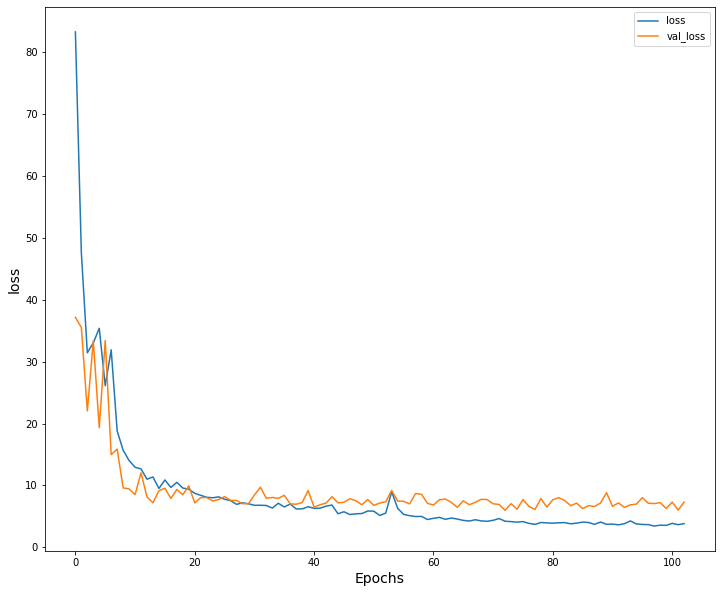

In [20]:
def plot_graphs(history, string):
    plt.figure(figsize=(12, 10))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(string, fontsize=14)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "loss")

### 2) 평가

In [21]:
model = tf.keras.models.load_model('best_model.h5')

In [22]:
results = model.evaluate(x_test, y_test, batch_size=64)

15/15 [==============================] - 1s 28ms/step - loss: 6.0352 - mean_absolute_error: 1.3967


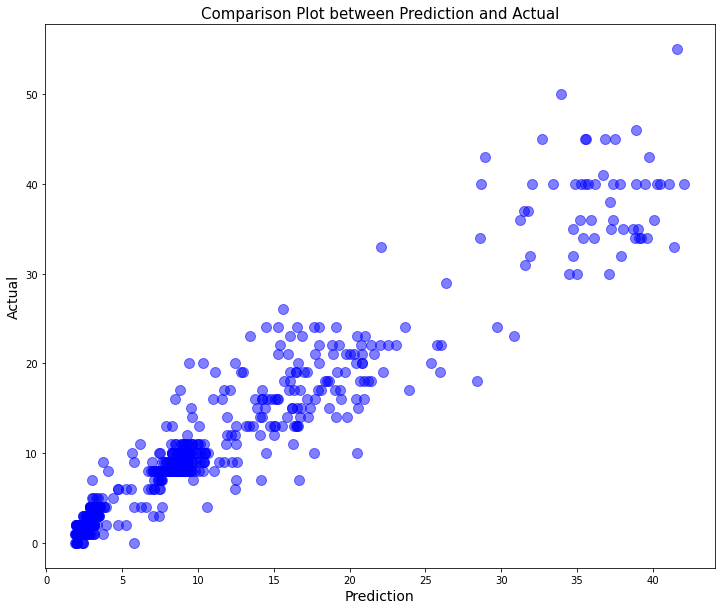

In [23]:
result = pd.DataFrame({'Predict':[x[0] for x in model(x_test).numpy()],'Actual':y_test})
plt.figure(figsize=(12, 10))
plt.plot(result['Predict'],result['Actual'],
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='blue', 
         alpha=0.5
)
plt.title('Comparison Plot between Prediction and Actual', fontsize=15)
plt.xlabel("Prediction", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.show()

In [24]:
result.corr(method='pearson')

,Predict,Actual
Predict,1.000000,0.964938
Actual,0.964938,1.000000


### 3) Score 예측 비교 Sample

In [25]:
result.sample(n=20,replace=False)

,Predict,Actual
1055,8.507240,8
4275,2.504084,2
544,8.842038,8
455,7.884181,9
4738,2.529541,2
6276,3.147917,3
174,8.689414,8
1546,10.343620,9
5082,1.943252,1
3913,3.105247,3


In [29]:
from sklearn.metrics import cohen_kappa_score
y_pred = np.around([x[0] for x in model(x_test).numpy()])
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')

In [33]:
print("Quadratic weighted kappa score : ",result)

Quadratic weighted kappa score :  0.9638319006580974
